In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/ML_cnsp_predict_self.csv")
df.head(5)
df.drop(['BC_CD'],axis=1)

,MONTH_YR,ANNUAL_CNSP
0,01-03-2004,289732624
1,01-04-2004,334337898
2,01-05-2004,344945161
3,01-06-2004,319604847
4,01-07-2004,316587509
...,...,...
216,01-03-2022,573447675
217,01-04-2022,709592127
218,01-05-2022,731431463
219,01-06-2022,737157846


In [ ]:
df.index = pd.to_datetime(df['MONTH_YR'], format='%d-%m-%Y')

In [ ]:
del df['MONTH_YR']

Text(0.5, 0, 'Date')

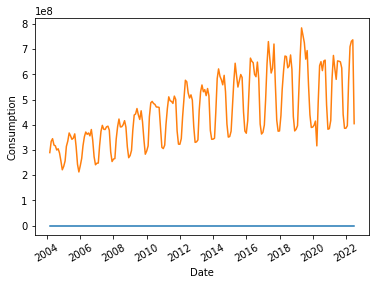

In [ ]:
plt.plot(df)
plt.xticks(rotation=30)
plt.ylabel('Consumption')
plt.xlabel('Date')


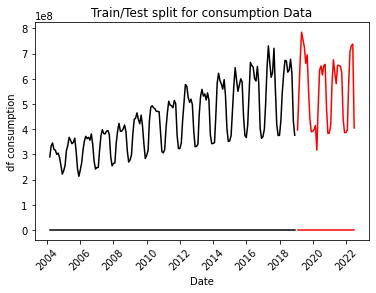

In [ ]:
train = df[df.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = df[df.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('df consumption')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for consumption Data")
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


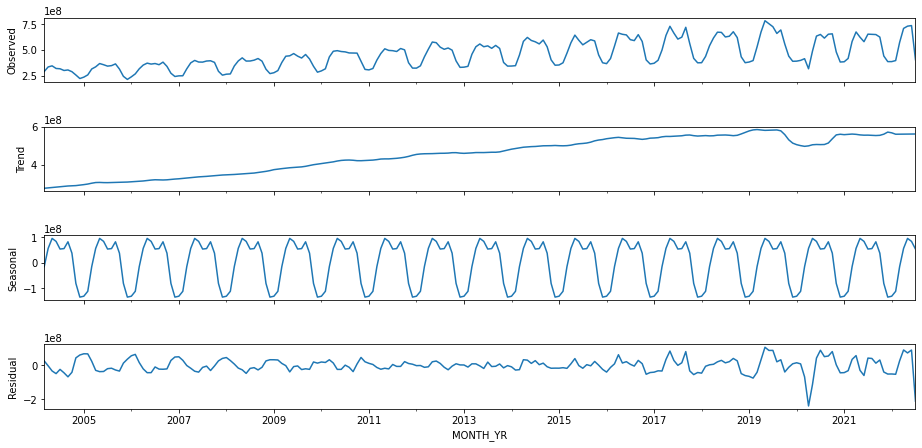

In [ ]:
import statsmodels.api as sm
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(df['ANNUAL_CNSP'])

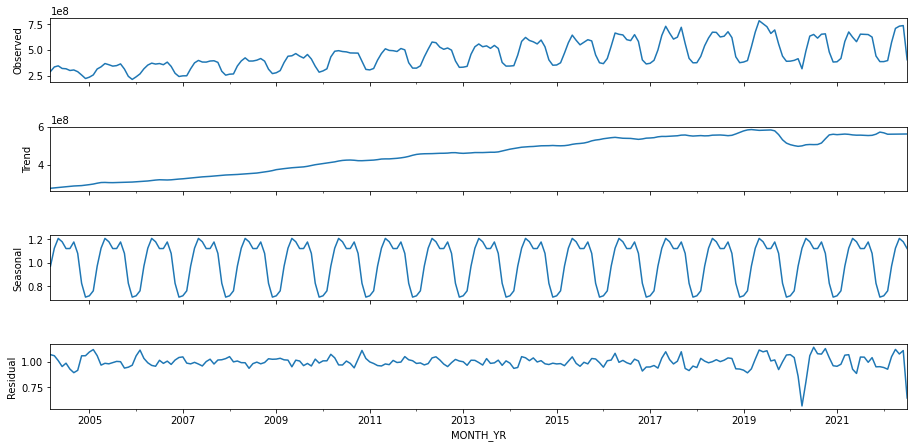

In [ ]:
import statsmodels.api as sm
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(df['ANNUAL_CNSP'])

In [ ]:
y = df['ANNUAL_CNSP']
y_to_train = train['ANNUAL_CNSP']
y_to_test = test['ANNUAL_CNSP']

In [ ]:
train['ANNUAL_CNSP'].shape


(178,)

In [ ]:
test['ANNUAL_CNSP'].shape

(42,)

After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing trend as well as a half yearly seasonality. From our graph we can say that we have multiplicative seasonal data. So we are choosing 
**Holt-Winters’ Seasonal Method**


In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
        print(f'Mean Absolute Error = {mean_absolute_error(y_to_test,fcast2)}')
        print(f'Mean Squared Error = {mean_squared_error(y_to_test,fcast2)}')
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        print(f'Mean Absolute Error = {mean_absolute_error(y_to_test,fcast4)}')
        print(f'Mean Squared Error = {mean_squared_error(y_to_test,fcast4)}')
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 96943196.34
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 96943196.34
Mean Absolute Error = 82967070.46494
Mean Squared Error = 1.1889493044629158e+16


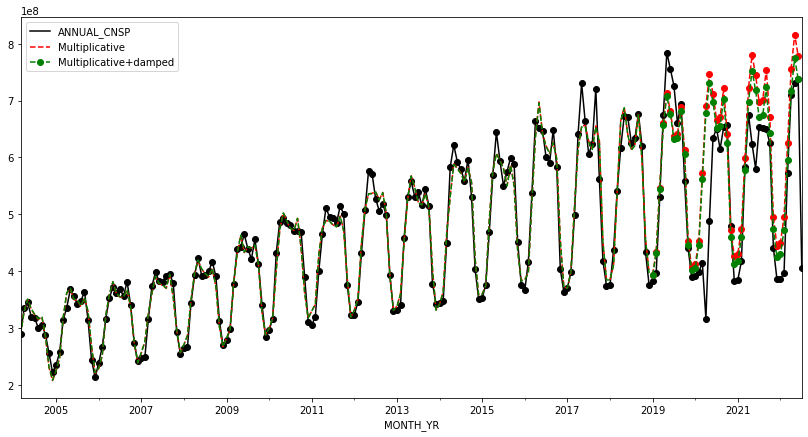

In [ ]:
holt_win_sea(y, y_to_train,y_to_test,'multiplicative',12, 42)

#very good model, MSE is low.

### NOW TESTING WITH SARIMAX MODEL
SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) 
### First step : autocorrelation plot

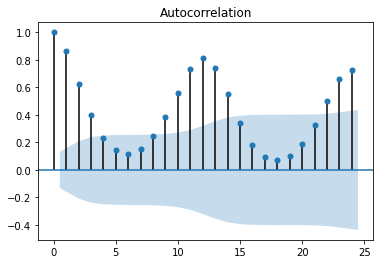

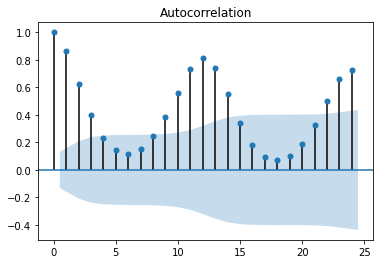

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.ANNUAL_CNSP)

#Here null hypothes is “Time series is stationary”
Test Stationrity.
1.Visual Method
2.Null Hypothesis Testing

In [ ]:
# Visual Method
def test_stationary(timeseries) :
     import matplotlib.pyplot as plt
     rollmean = timeseries.rolling(window=12).mean()
     rollstd = timeseries.rolling(window=12).std()
     plt.plot(timeseries,label='original')
     plt.plot(rollmean,label='Rolling Mean')
     plt.plot(rollstd,label='Rolling Standard Deviation')
     plt.legend(loc='best')
     plt.title('Timeseries data with Rolling mean and standard dev')
     plt.show();

def fullertest(timeseries) :  
        from statsmodels.tsa.stattools import adfuller
        dftest = adfuller(timeseries, autolag = 'AIC')
        print("1. ADF : ",dftest[0])
        print("2. P-Value : ", dftest[1])
        print("3. Num Of Lags : ", dftest[2])
        print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
        print("5. Critical Values :")
        for key, val in dftest[4].items():
             print("\t",key, ": ", val) 

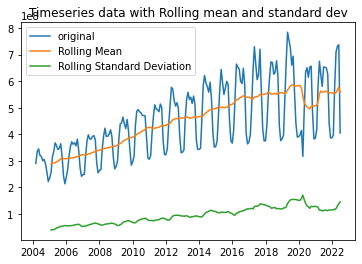

1. ADF :  -1.7242998769843687
2. P-Value :  0.4186379323266971
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 209
5. Critical Values :
	 1% :  -3.4620315036789666
	 5% :  -2.8754705024827127
	 10% :  -2.5741950726860647


In [ ]:
test_stationary(y)
fullertest(y)

Treand and seasonality clearly visivle

Here in the results, we can see that the p-value for time series is greater than 0.05, and we can say we fail to reject the null hypothesis and the time series is non-stationary. 

Log scale transformation

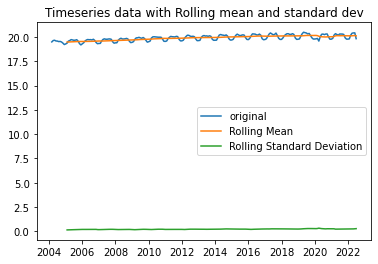

1. ADF :  -2.1268378918375546
2. P-Value :  0.23386076255160587
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 208
5. Critical Values :
	 1% :  -3.4621857592784546
	 5% :  -2.875537986778846
	 10% :  -2.574231080806213


In [ ]:
y_log_scaled = np.log(y)
test_stationary(y_log_scaled )
fullertest(y_log_scaled)

Now the variance is very low. Data is seasonal.

Still P value not less than 0.05, data is non stationary


####  So substracting yearly rolloing average (minus ma)

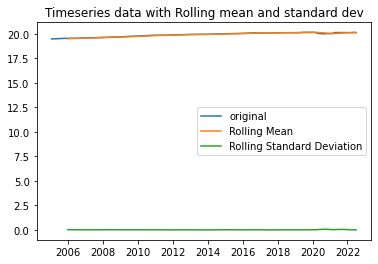

1. ADF :  -3.2884215241178305
2. P-Value :  0.01540403261390999
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 194
5. Critical Values :
	 1% :  -3.4645146202692527
	 5% :  -2.8765564361715534
	 10% :  -2.5747745328940375


In [ ]:
Y_after_rolling = y_log_scaled.rolling(window=12).mean()
Y_after_rolling  = Y_after_rolling .dropna()
test_stationary(Y_after_rolling )
fullertest(Y_after_rolling)


**Now P value is very less so data is stationary, accept Null hypothesis**


#####Find the d value

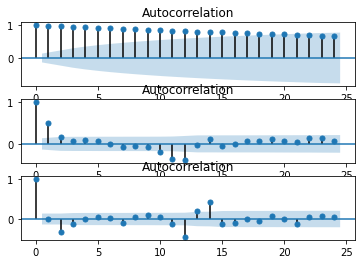

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(Y_after_rolling, ax=ax1);
plot_acf(Y_after_rolling.diff().dropna(), ax=ax2);
plot_acf(Y_after_rolling.diff().diff().dropna(), ax=ax3);

##### find the p value

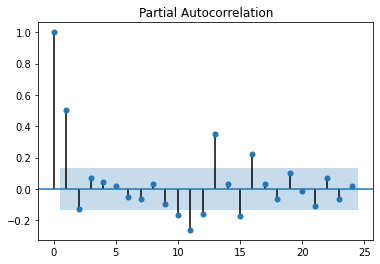

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Y_after_rolling.diff().dropna());

##### find the value of q

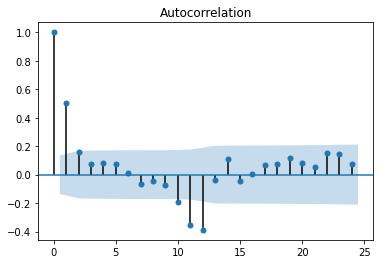

In [ ]:
plot_acf(Y_after_rolling.diff().dropna());

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Y_after_rolling, order = (2,2,6))
model_fit = model.fit(disp=0)
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D2.ANNUAL_CNSP   No. Observations:                  208
Model:                 ARIMA(2, 2, 6)   Log Likelihood                 726.460
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 15 Aug 2022   AIC                          -1432.920
Time:                        15:53:13   BIC                          -1399.544
Sample:                    04-01-2005   HQIC                         -1419.424
                         - 07-01-2022                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.565e-05   2.15e-05     -1.655      0.099   -7.79e-05    6.56e-06
ar.L1.D2.ANNUAL_CNSP     0.0239      0.097      0.247      0.805      -0.166       0.214
ar.L2.D2.ANNUAL_CNSP    -0.7300      0.082     -8.870      0.000      -0.891      -0.569
ma.L1.D2.ANNUAL_CNSP    -0.2084      0.145     -1.436      0.153      -0.493       0.076
ma.L2.D2.ANNUAL_CNSP     0.2733      0.140      1.951      0.053      -0.001       0.548
ma.L3.D2.ANNUAL_CNSP    -0.4121      0.067     -6.160      0.000      -0.543      -0.281
ma.L4.D2.ANNUAL_CNSP    -0.5841      0.063     -9.261      0.000      -0.708      -0.460
ma.L5.D2.ANNUAL_CNSP    -0.1498      0.125     -1.203      0.230      -0.394       0.094
ma.L6.D2.ANNUAL_CNSP     0.1260      0.130      0.972      0.332      -0.128       0.380
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0164           -1.1703j            1.1704           -0.2478
AR.2            0.0164           +1.1703j            1.1704            0.2478
MA.1           -0.0149           -1.0037j            1.0039           -0.2524
MA.2           -0.0149           +1.0037j            1.0039            0.2524
MA.3            1.0137           -0.0000j            1.0137           -0.0000
MA.4           -1.3990           -0.7937j            1.6085           -0.4179
MA.5           -1.3990           +0.7937j            1.6085            0.4179
MA.6            3.0025           -0.0000j            3.0025           -0.0000
-----------------------------------------------------------------------------
"""

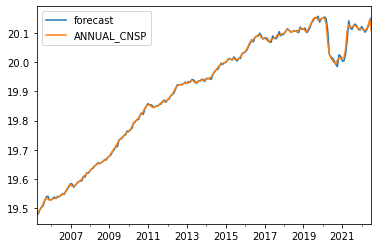

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

Our Model is good enough still for testing purpose, we are doing Auto ARIMA

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 30.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pmdarima as pm

In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['ANNUAL_CNSP'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      stationary=False,
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

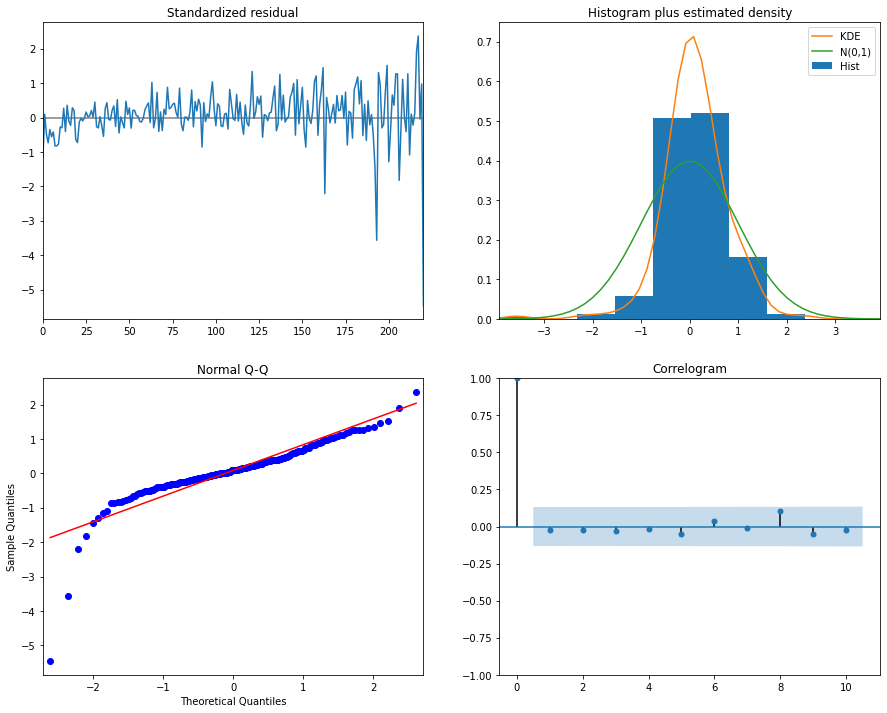

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

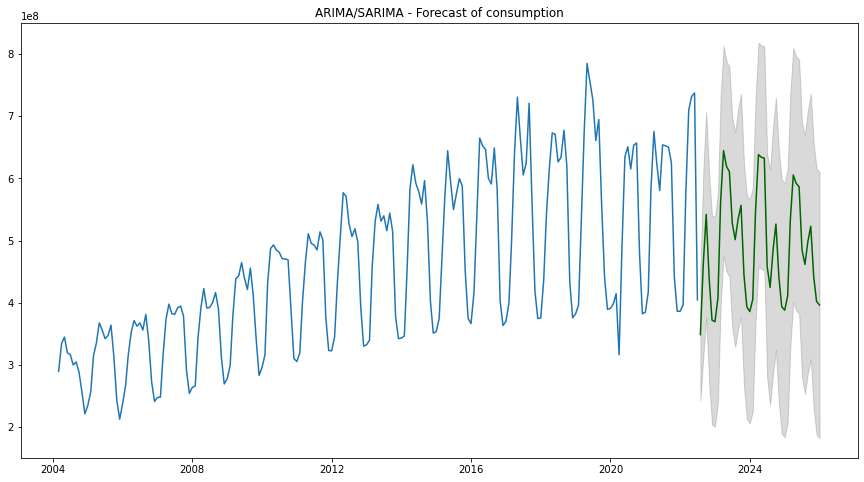

In [ ]:
def forecast(ARIMA_model, periods=42):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,8))
    plt.plot(df['ANNUAL_CNSP'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of consumption")
    plt.show()

forecast(ARIMA_model)